In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import get_project_root
from data_statistical_features import Segment
from ml_statistical_features import load_data_as_dataframe

import os

# Load Data

In [2]:
df = load_data_as_dataframe(segment_length=10, overlap_amount=0, hr_threshold=10)

features = df.drop(['brueser_sqi', 'patient_id', 'informative', 'ecg_hr', 'bcg_hr', 'abs_err', 'rel_err', 'quality_class', 'error'], axis='columns')
target = df['informative']
error = df['error']
bcg_hr = df['bcg_hr']
ecg_hr = df['ecg_hr']
patient_id = df['patient_id']

# Informative per patient

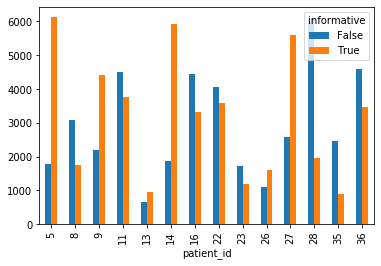

In [3]:
pd.crosstab(df['patient_id'],df['informative']).plot.bar()

# Correlation Heatmap

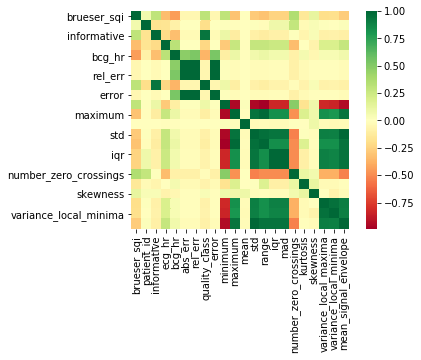

In [4]:
sns.heatmap(df.corr(), square=True, cmap ="RdYlGn")

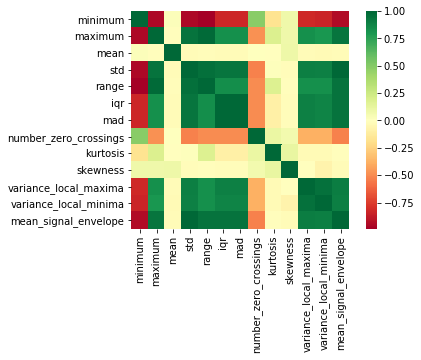

In [5]:
sns.heatmap(features.corr(), square=True, cmap ="RdYlGn")

# Paarweise geplottet

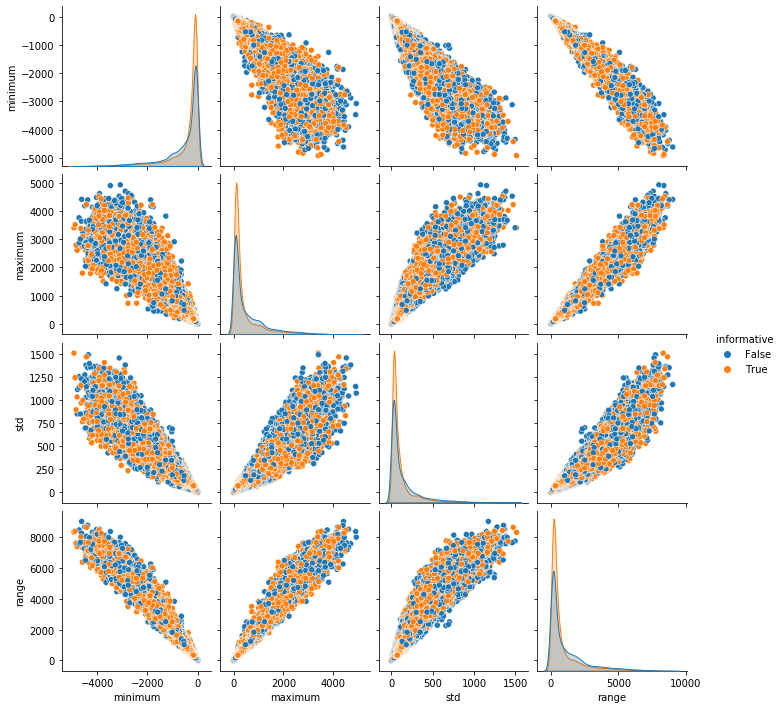

In [6]:
cols = ['minimum', 'maximum', 'std', 'range', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

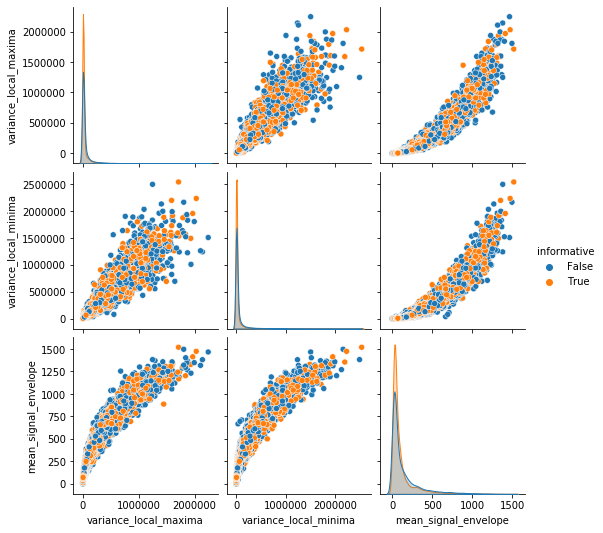

In [7]:
cols = ['variance_local_maxima', 'variance_local_minima', 'mean_signal_envelope', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

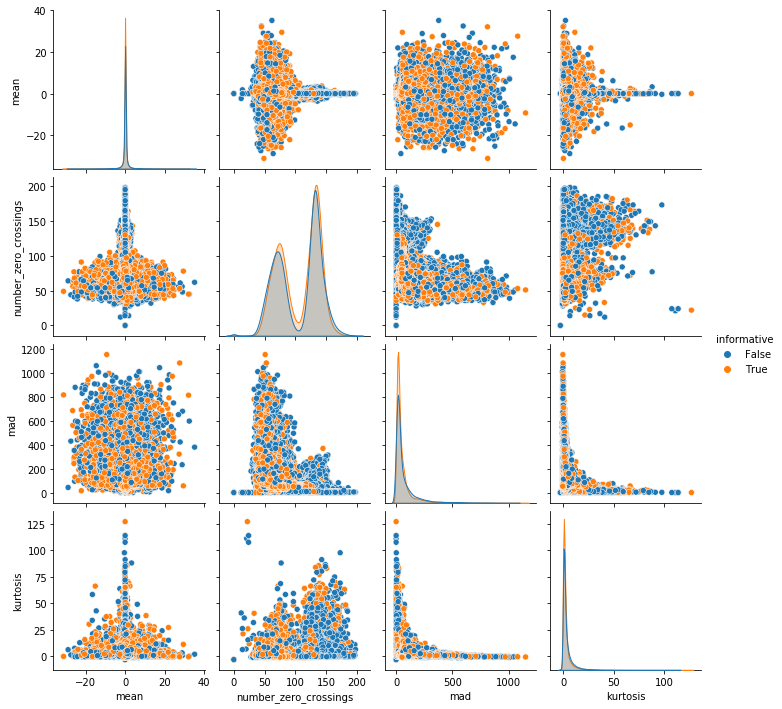

In [8]:
cols = ['mean', 'number_zero_crossings', 'mad', 'kurtosis', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

# Boxplots features

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,35))

df.boxplot(column=['minimum'],by='informative', ax=axes[0,0])
df.boxplot(column=['maximum'],by='informative', ax=axes[0,1])
df.boxplot(column=['mean'],by='informative', ax=axes[1,0])
df.boxplot(column=['std'],by='informative', ax=axes[1,1])
df.boxplot(column=['range'],by='informative', ax=axes[2,0])
df.boxplot(column=['iqr'],by='informative', ax=axes[2,1])
df.boxplot(column=['mad'],by='informative', ax=axes[3,0])
df.boxplot(column=['number_zero_crossings'],by='informative', ax=axes[3,1])
df.boxplot(column=['kurtosis'],by='informative', ax=axes[4,0])
df.boxplot(column=['skewness'],by='informative', ax=axes[4,1])
df.boxplot(column=['variance_local_maxima'],by='informative', ax=axes[5,0])
df.boxplot(column=['mean_signal_envelope'],by='informative', ax=axes[5,1])
# TODO: deal with inf values


plt.show()

# Fazit
- stark korrelierende Merkmale
- Dimensionsreduktion zur Reduzierung von stark korrelierenden Merkmalen sinnvoll
- keine klare Verteilung von informativ und nicht informativ, große Überlappung

# Einfluss der Merkmale bei Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from ml_statistical_features import get_patient_split

In [10]:
mask = df['error'] > 1000
df.loc[mask, 'error'] = 667

In [11]:
forest = RandomForestClassifier(random_state=1, class_weight='balanced')
x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.2)

forest.fit(features, target)
print(forest.score(x_train, y_train))

0.9998591846792931


In [12]:
y_train_regr = error.loc[y_train.index]
y_test_regr = error.loc[y_test.index]

In [13]:
forest_regr = RandomForestRegressor(random_state=1)

forest_regr.fit(x_train, y_train_regr)
forest_regr.score(x_test, y_test_regr)

0.26659294903757613

403.45985799509117
MSE: 642.3190154973894
MAE: 15.10575479172109
                 precision    recall  f1-score   support

non-informative       0.56      0.82      0.66      7868
    informative       0.54      0.25      0.34      6826

       accuracy                           0.55     14694
      macro avg       0.55      0.53      0.50     14694
   weighted avg       0.55      0.55      0.51     14694



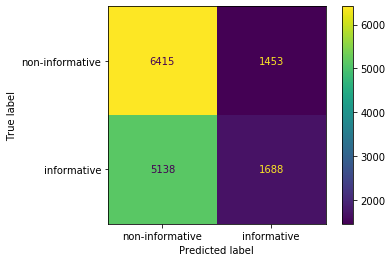

In [14]:
y_pred = forest_regr.predict(x_test)
y_true = y_test_regr

print(np.max(y_pred))

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error

print("MSE: " + str(mean_squared_error(y_true, y_pred)))
print("MAE: " + str(mean_absolute_error(y_true, y_pred)))

y_pred_label = [err < 10 for err in y_pred]
y_true_label = [err < 10 for err in y_true]

class_names = ['non-informative', 'informative']
ConfusionMatrixDisplay(confusion_matrix(y_true_label, y_pred_label), display_labels=class_names).plot()
print(classification_report(y_true_label, y_pred_label, target_names=class_names))

 1) number_zero_crossings          0.091034
 2) skewness                       0.090423
 3) variance_local_maxima          0.079460
 4) kurtosis                       0.079241
 5) maximum                        0.078997
 6) iqr                            0.077315
 7) mad                            0.077122
 8) variance_local_minima          0.074573
 9) range                          0.073933
10) mean_signal_envelope           0.072535
11) minimum                        0.070045
12) std                            0.069437
13) mean                           0.065883


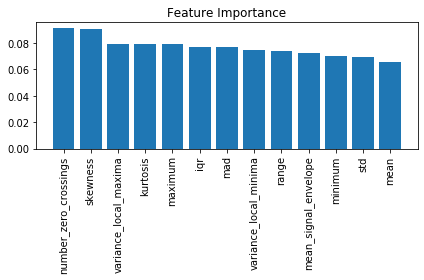

In [15]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [16]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

In [17]:
std_scaler = StandardScaler()

x_std = std_scaler.fit_transform(x_test)

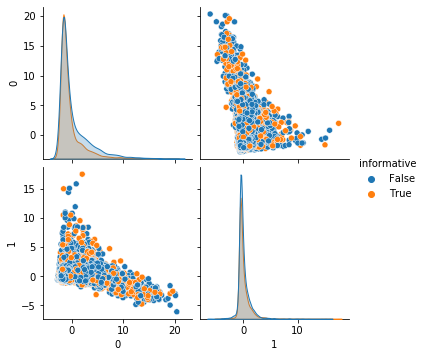

In [18]:
pca = KernelPCA(n_components=2)
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

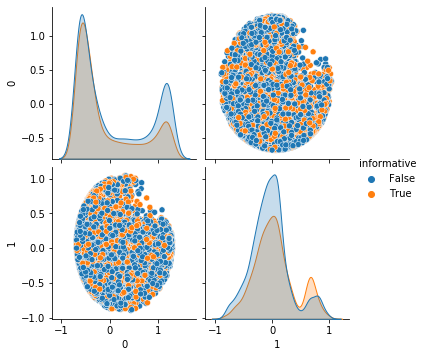

In [19]:
pca = KernelPCA(n_components=2, kernel='cosine')
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

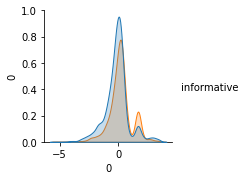

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=1)
clf.fit(x_std, y_test)
x_lda = clf.transform(x_std)
df_lda = pd.DataFrame(x_lda)
df_lda['informative'] = y_test.values

sns.pairplot(df_lda, kind='scatter', hue='informative')

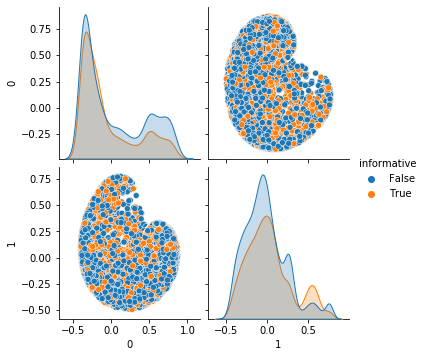

In [21]:
pca = KernelPCA(n_components=2, kernel='rbf', degree=3)
x_transform = pca.fit_transform(x_std)

df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

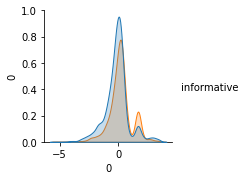

In [22]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

nca = NeighborhoodComponentsAnalysis(n_components=2)
x_nca = nca.fit_transform(x_std, y_test)

df_nca = pd.DataFrame(x_lda)
df_nca['informative'] = y_test.values

sns.pairplot(df_nca, kind='scatter', hue='informative')